# Image Classification for American Sign Language (ASL)

This project is to classified each ASL sign language with it's respective classes. There are 24 classes excluding J and Z as they are motion gesture. In this project, we are going to use our own set of captured data and train our own model to detect ASL sign language. 

# Setup Config

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

# most import image processing library, OpenCV as cv2
import cv2
from imutils.paths import list_images

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [2]:
# check whether have access to GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

If this returns an empty list then there is either something wrong with your tensorflow installation, or your machine has no GPU. If you want to use TensorFlow with GPU (recommended), please check this [video link here](https://youtu.be/hHWkvEcDBO0) to try to debug and make sure the cell above returns something like this:

`[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]`

<br>

Usually it's better to setup all these configs in another script named as `config.py` for convenience, but since we are using notebooks, we setup all the config at the beginning of the notebooks.

In [3]:
# File directory to the training folder.
# Follow the config setup in the image collection notebook, or your own folder,
# consisting of one "training" folder, one "validation" folder, and one "testing" folder
DATASET_DIR = "dataset"

# Setup training, validation and testing paths
# These paths should point to your directories containing training and validation set images
TRAIN_PATH = os.path.join(DATASET_DIR, "training")
VAL_PATH = os.path.join(DATASET_DIR, "validation")

# directory to the train set images
# NOTE: these images will not be touched during training
#  to avoid data leakage
TEST_PATH = os.path.join(DATASET_DIR, "testing")

# Path to model's related components
OUTPUTS_PATH = "outputs"
if not os.path.exists(OUTPUTS_PATH):
    os.makedirs(OUTPUTS_PATH)

# number of classes = 24 not including 'J' and 'Z' as they are motion gesture
CLASS_NAMES = ["A", "B", "C", "D", "E", "F", "G", "H", "I", 
               "K", "L", "M", "N", "O", "P", "Q", "R",
               "S", "T", "U", "V", "W", "X", "Y"]

## Training Config

In [4]:
# initialize the initial learning rate, batch size, and number of
# epochs to train for
INIT_LR = 1e-4
BATCH_SIZE = 32 # Number of training examples used in one iteration of training
NUM_EPOCHS = 10

IMG_HEIGHT = 80 # height of image to resize to
IMG_WIDTH = 80 # width of image to resize to

In [5]:
from datetime import datetime
# define the path to the serialized output model after training
MODEL_PATH = os.path.join(OUTPUTS_PATH, f"sign_detector_{datetime.today().date()}.model")

# path to save the classification report of accuracy, precision etc.
CLASSIF_REPORT_PATH = os.path.join(OUTPUTS_PATH, "classification_report.txt")

# path to output loss/accuracy plot
PLOT_PATH = os.path.join(OUTPUTS_PATH, "plot.png")

# Inspecting Images

dataset\training\A\A_411.jpg


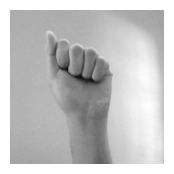

dataset\training\B\B_386.jpg


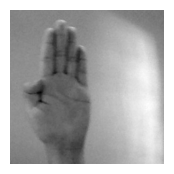

dataset\training\C\C_119.jpg


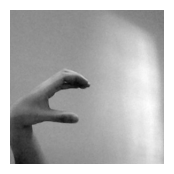

dataset\training\D\D_221.jpg


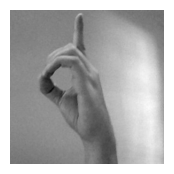

dataset\training\E\E_505.jpg


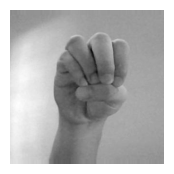

dataset\training\F\F_329.jpg


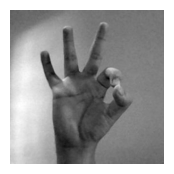

dataset\training\G\G_167.jpg


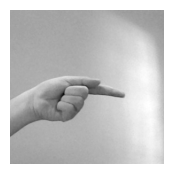

dataset\training\H\H_321.jpg


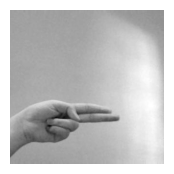

dataset\training\I\I_232.jpg


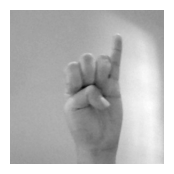

dataset\training\K\K_279.jpg


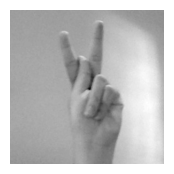

dataset\training\L\L_389.jpg


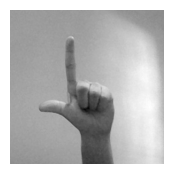

dataset\training\M\M_488.jpg


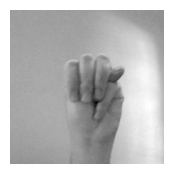

dataset\training\N\N_281.jpg


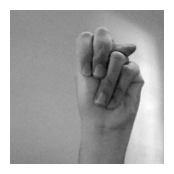

dataset\training\O\O_202.jpg


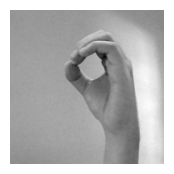

dataset\training\P\P_420.jpg


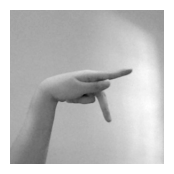

dataset\training\Q\Q_449.jpg


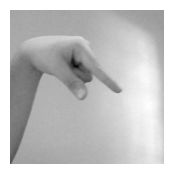

dataset\training\R\R_203.jpg


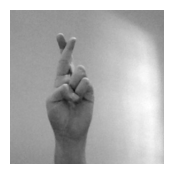

dataset\training\S\S_456.jpg


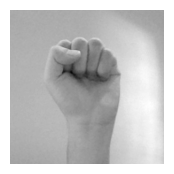

dataset\training\T\T_296.jpg


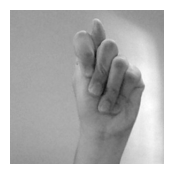

dataset\training\U\U_476.jpg


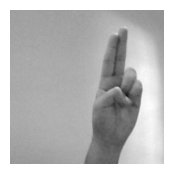

dataset\training\V\V_497.jpg


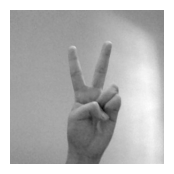

dataset\training\W\W_225.jpg


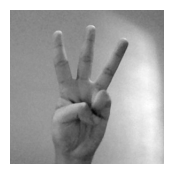

dataset\training\X\X_427.jpg


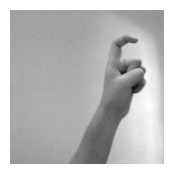

dataset\training\Y\Y_215.jpg


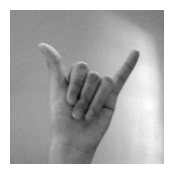

In [4]:
for i in CLASS_NAMES:
    class_path = os.path.join(TRAIN_PATH, i)
    img_paths = list(list_images(class_path))
    # checking one random image from each class
    for img_path in np.random.choice(img_paths, 1):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.figure(figsize=(2, 2))
        plt.axis('off')
        plt.imshow(img, cmap="gray")
        plt.show()

In [5]:
# checking the shape of the image
# (height, width, channel)
# 1 channel for grayscale images, but not shown at the 3rd dimension here
# because we loaded the image using OpenCV in grayscale mode
print(img.shape)

(320, 320)


resized_img.shape = (50, 50)


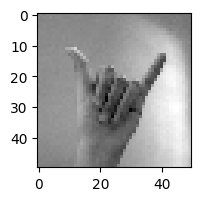

In [6]:
## Showing how to resize image
IMG_SIZE = 50

resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
print(f"resized_img.shape = {resized_img.shape}")
plt.figure(figsize=(2, 2))
plt.imshow(resized_img, cmap = 'gray')
plt.show()

# FIRST METHOD: Creating dataset and showing data augmentation

`ImageDataGenerator` class is generally the easiest method to use to load and augment image datasets. Therefore, we would start with this simplest approach first.

Later, we will use a more advanced method using `tf.data` API, which will result in much faster training and inference times, at the cost of slightly more complex and longer code.

In [ ]:
# initialize the training data augmentation object
# this will create images with different characteristics
#  ON THE FLY during training
# You may refer to the documentation here for more details and choices
# https://keras.io/api/preprocessing/image/#imagedatagenerator-class
trainAug = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# initialize the validation/testing data augmentation object
# we DO NOT want to augment/alter the validation or test set
valAug = ImageDataGenerator()

# initialize the training generator
trainGen = trainAug.flow_from_directory(
    TRAIN_PATH,
    # set "categorical" for 2D one-hot encoded labels
    # you can see an example output at the cell below
    class_mode="categorical",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # our image only needs grayscale.
    # set to "rgb" if using RGB colors
    color_mode="grayscale",
    # only shuffle the training set
    shuffle=True,
    batch_size=BATCH_SIZE,
)

# initialize the validation generator
valGen = valAug.flow_from_directory(
    VAL_PATH,
    class_mode="categorical",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="grayscale",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

# initialize the testing generator
testGen = valAug.flow_from_directory(
    TEST_PATH,
    class_mode="categorical",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="grayscale",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

In [104]:
# take the first batch of images and labels
batch_images, batch_labels = next(trainGen)
print(batch_images.shape)
print(batch_labels.shape)

# resets the generator to the first batch after we have checked the first batch
trainGen.reset()

(32, 80, 80, 1)
(32, 24)


In [105]:
# the labels are one-hot-encoded
batch_labels[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

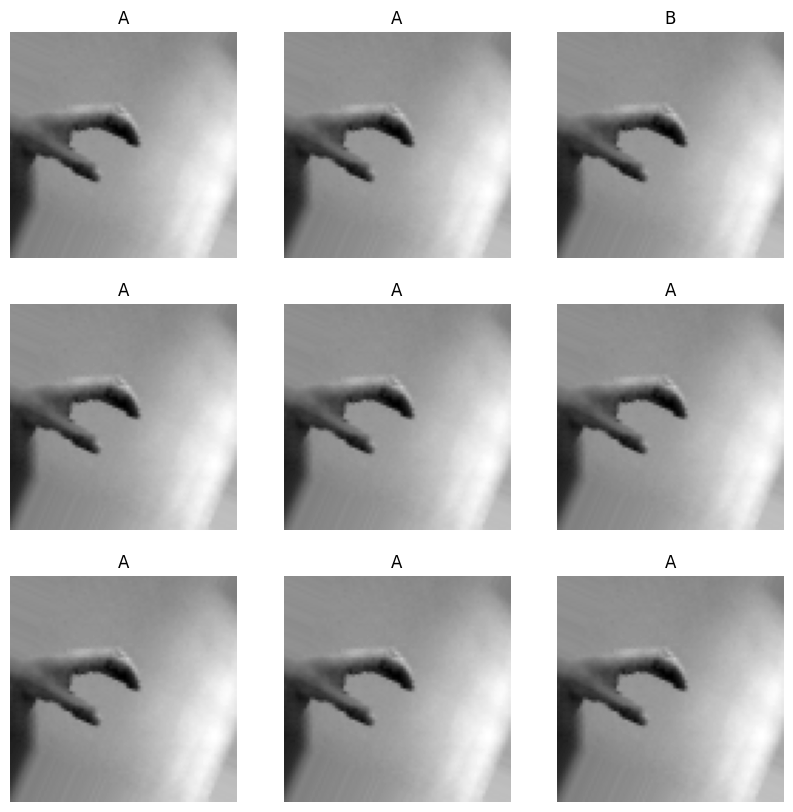

In [106]:
## Showing a batch of images with labels

plt.figure(figsize=(10,10))
i = 0
for img, label in zip(batch_images, batch_labels):
    # show only 9 images
    while i < 9:
        # with 3 rows and 3 columns
        ax = plt.subplot(3, 3, i+1)
        # show in grayscale
        plt.imshow(img, cmap='gray')
        # add the label name on top
        plt.title(CLASS_NAMES[int(label[i])])
        plt.axis('off')
        i += 1
plt.show()

# Build the model

In [45]:
num_classes = len(CLASS_NAMES)

def create_model():
    # clear global states to regain memory
    tf.keras.backend.clear_session()
    model = Sequential([
        # 1st conv block
        # only the first layer needs to specify an InputLayer
        # the third dimension is 1 to represent grayscale (1-channel),
        # if the images are in RGB, then we set to 3 channels
        layers.InputLayer((IMG_HEIGHT, IMG_WIDTH, 1)),
        # a common block of Convolutional Neural Network layer + Max Pooling layer
        # with 'same' padding and ReLU activation function
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),

        # 2nd conv block
        # generally doubling the number of feature maps every time after Max Pooling
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),

        # 3rd conv block
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),

        # 4th conv block
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        # adding a DropOut layer to have 0.5 chance of removing 
        # certain neural network nodes to overcome overfitting
        layers.Dropout(0.5), 
        # the last layer's nodes must follow the number of classes available
        layers.Dense(num_classes)
    ])

    model.compile(optimizer='adam',
                  # use CategoricalCrossentropy for one-hot encoded labels.
                  # And if we did not specify `softmax` at the final layer,
                  #  we must specify `from_logits=True` here, it works the same
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 256)       2

# Training

In [155]:
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(list_images(TRAIN_PATH)))
totalVal = len(list(list_images(VAL_PATH)))
totalTest = len(list(list_images(TEST_PATH)))
print(totalTrain)
print(totalVal)
print(totalTest)

8316
924
3080


In [164]:
## defining some extra callbacks to use, this is not necessary for training
#  they are just used for quality of life

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# this callback saves the checkpoint with the best `val_loss` after training
checkpoint_filepath = os.path.join(OUTPUTS_PATH, 'weights.h5')
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

# this callback will stop the training when the `val_loss` has not changed for
#   3 epochs, as specified by the `patience` parameter
# `restore_best_weights` is used to restore the model to the best checkpoint 
#   after training
early_stopping = EarlyStopping(patience=3, monitor='val_loss',
                               mode='min', restore_best_weights=True)

In [157]:
# train the model
print("[INFO] training model...")
start_time = time.perf_counter()
H = model.fit(
    trainGen,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=valGen,
    validation_steps=totalVal // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[model_checkpoints, early_stopping],
)
time_elapsed = time.perf_counter() - start_time
print(
    f"\n[INFO] Time taken for training: {time_elapsed//60} minutes {time_elapsed%60:.0f} seconds...\n"
)

[INFO] training model...
Epoch 1/10
259/259 [==============================] - 10s 36ms/step - loss: 3.3156 - accuracy: 0.1727 - val_loss: 1.3015 - val_accuracy: 0.6295
Epoch 2/10
259/259 [==============================] - 9s 36ms/step - loss: 1.1072 - accuracy: 0.6552 - val_loss: 0.3160 - val_accuracy: 0.8806
Epoch 3/10
259/259 [==============================] - 10s 37ms/step - loss: 0.4089 - accuracy: 0.8677 - val_loss: 0.0903 - val_accuracy: 0.9654
Epoch 4/10
259/259 [==============================] - 9s 35ms/step - loss: 0.2522 - accuracy: 0.9168 - val_loss: 0.1013 - val_accuracy: 0.9766
Epoch 5/10
259/259 [==============================] - 10s 40ms/step - loss: 0.1702 - accuracy: 0.9446 - val_loss: 0.0193 - val_accuracy: 0.9944
Epoch 6/10
259/259 [==============================] - 10s 39ms/step - loss: 0.1080 - accuracy: 0.9684 - val_loss: 0.0441 - val_accuracy: 0.9866
Epoch 7/10
259/259 [==============================] - 10s 38ms/step - loss: 0.1234 - accuracy: 0.9611 - val_loss:

# Visualize training results

Total epochs: 10
Min val_loss: 0.00907 at epoch 7



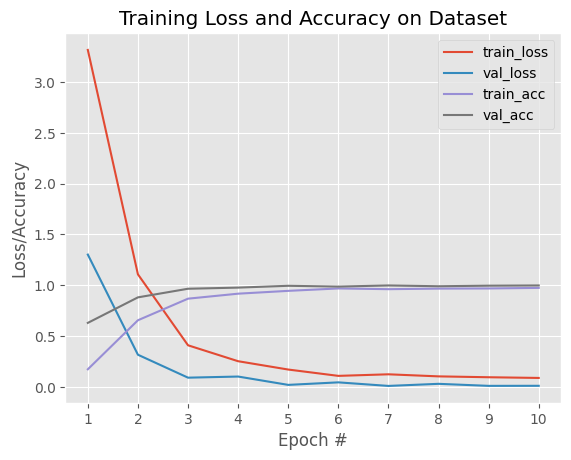

In [160]:
val_loss = H.history["val_loss"]
min_val_loss = np.min(val_loss)
epoch_min_val_loss = val_loss.index(min_val_loss) + 1
total_epochs = len(val_loss)
print(f"Total epochs: {total_epochs}")
print(f"Min val_loss: {min_val_loss:.5f} at epoch {epoch_min_val_loss}\n")

N = NUM_EPOCHS
plt.style.use("ggplot")
plt.xticks(np.arange(1, N + 1))
plt.plot(np.arange(1, N + 1), H.history["loss"], label="train_loss")
plt.plot(np.arange(1, N + 1), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(1, N + 1), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(1, N + 1), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
# save the figure
plt.savefig(PLOT_PATH)
plt.show()

# Evaluation

In [168]:
# reset the testing generator and then use our trained model to
# make predictions on the data
start_time = time.perf_counter()
print("[INFO] evaluating network...")
testGen.reset()
predIdxs = model.predict(testGen, steps=(totalTest // BATCH_SIZE) + 1)
time_elapsed = time.perf_counter() - start_time
print(
    f"\n[INFO] Time taken for evaluation: {time_elapsed//60} minutes {time_elapsed%60:.0f} seconds...\n"
)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

[INFO] evaluating network...

[INFO] Time taken for evaluation: 0.0 minutes 2 seconds...



In [169]:
from sklearn.metrics import classification_report

# show a nicely formatted classification report
classif_report = classification_report(
    testGen.classes, predIdxs, target_names=testGen.class_indices.keys()
)
print(classif_report)
with open(CLASSIF_REPORT_PATH, "w") as f:
    f.write(classif_report)

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       107
           B       0.93      1.00      0.97       128
           C       1.00      1.00      1.00       139
           D       0.99      0.99      0.99       123
           E       1.00      0.93      0.97       137
           F       1.00      1.00      1.00       109
           G       1.00      1.00      1.00       114
           H       1.00      1.00      1.00       141
           I       0.99      1.00      1.00       123
           K       1.00      1.00      1.00       136
           L       1.00      1.00      1.00       131
           M       1.00      0.99      1.00       126
           N       0.99      1.00      1.00       128
           O       1.00      0.99      1.00       131
           P       1.00      0.98      0.99       147
           Q       1.00      1.00      1.00       127
           R       1.00      1.00      1.00       124
           S       1.00    

In [167]:
# serialize the model to disk
print("[INFO] saving model...")
model.save(MODEL_PATH, save_format="h5")

[INFO] saving model...


In [12]:
def load_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img.reshape(1, IMG_HEIGHT, IMG_WIDTH, 1)
    return img

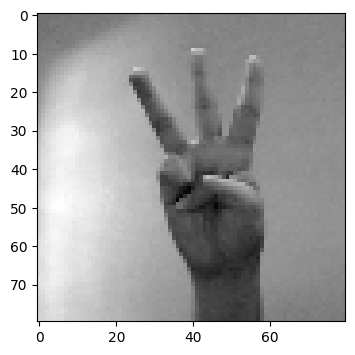

Predicted: W [100.00%]


In [18]:
import random

img_path = random.choice(list(list_images(TEST_PATH)))

img = load_and_preprocess(img_path)

predictions = model.predict(img)
score = tf.nn.softmax(predictions[0])
pred_class = CLASS_NAMES[np.argmax(score)]

plt.figure(figsize=(4, 4))
plt.imshow(img[0], cmap='gray')
plt.grid(False)
plt.show()

print(f"Predicted: {pred_class} [{100 * np.max(score):.2f}%]")

# Load model for Inference

In [6]:
# Load entire saved model directly
start_time = time.perf_counter()
print(f"[INFO] Loading model ...")
model = tf.keras.models.load_model(MODEL_PATH)
end_time = time.perf_counter()
print(f"[INFO] Done. [{end_time - start_time:.2f} s]")

[INFO] Loading model ...
[INFO] Done. [0.71 s]


In [9]:
## OR Load using checkpoint method
CHECKPOINT_PATH = os.path.join(OUTPUTS_PATH, "weights.h5")
start_time = time.perf_counter()
# create the model using the function defined in "Build model" section
model = create_model()
print(f"[INFO] Loading model checkpoint ...")
model.load_weights(CHECKPOINT_PATH)
end_time = time.perf_counter()
print(f"[INFO] Done. [{end_time - start_time:.2f} s]")

[INFO] Loading model checkpoint ...
[INFO] Done. [0.07 s]


In [10]:
imagePaths = list_images(TEST_PATH)

# initialize timer to calculate how long it takes to preprocess
# and make predictions
start_time = time.perf_counter()

# initialize lists for storing images data and labels
data = []
labels = []
for i, img_path in enumerate(imagePaths, start=1):
    # read and preprocess the image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    # add an extra dimension at the end to denote `grayscale`
    # of 1 channel
    img = np.expand_dims(img, -1)
    data.append(img)
    
    # extract the label from the folder name containing the image
    label = img_path.split(os.path.sep)[-2]
    labels.append(label)

data, label = np.array(data), np.array(label)
print("[INFO] Preprocess completed.")
print("[INFO] Data shape:", data.shape)

print("[INFO] Making predictions ...")
pred_probas = model.predict(data)
# take the index of the highest probabilty as our prediction
preds = np.argmax(pred_probas, axis=1)

# get the label names
pred_labels = np.array([CLASS_NAMES[i] for i in preds])
# calculate total correct predictions
total_correct_preds = np.sum(np.where(pred_labels == labels, True, False))
# calculate total wrong predictions
total_wrong_preds = len(pred_labels) - total_correct_preds
# end the timer
total_time = time.perf_counter() - start_time
print(f"[INFO] Done. {total_time:.2f} seconds")

[INFO] Preprocess completed.
[INFO] Data shape: (3080, 80, 80, 1)
[INFO] Making predictions ...
[INFO] Done. 3.43 seconds


In [11]:
print(total_correct_preds)
print(total_wrong_preds)

3064
16


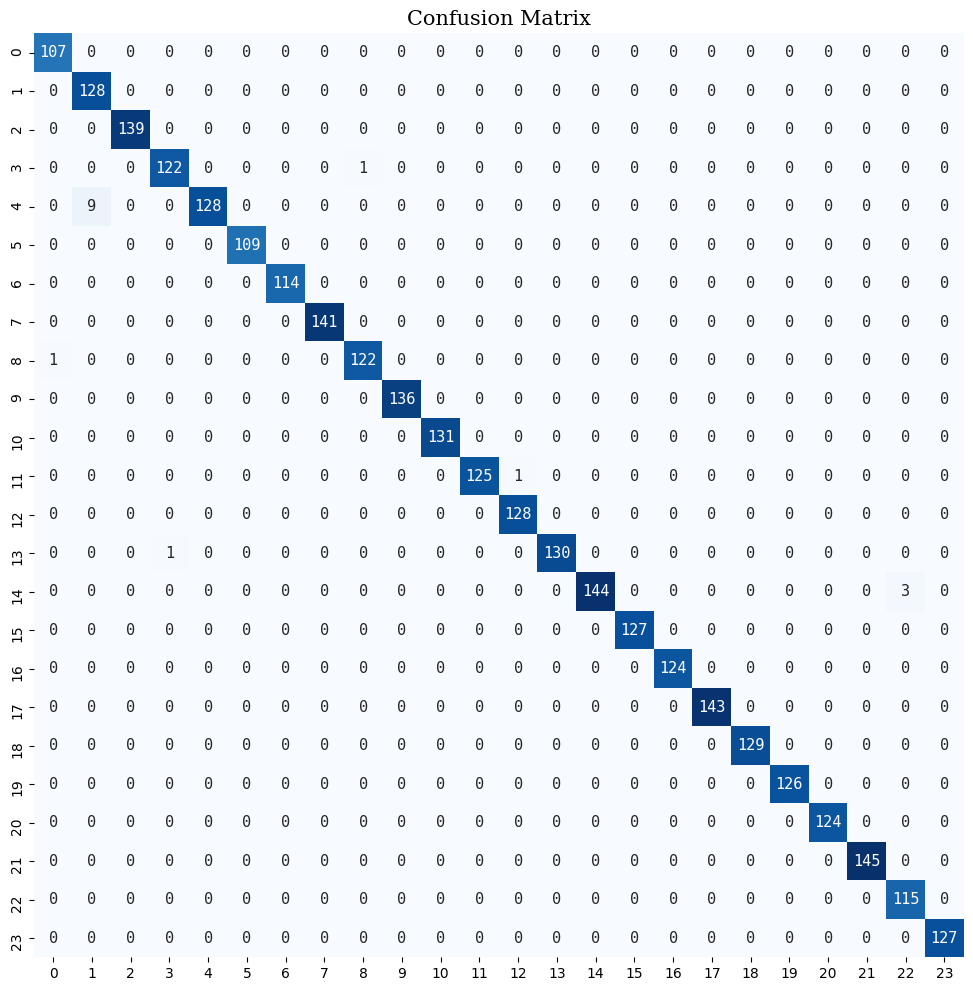

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, pred_labels)

fig = plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    cm,
    # use specific color
    cmap="Blues",
    # show numbers
    annot=True,
    # format to integer
    fmt="d",
    # don't show colorbar
    cbar=False,
    # format them to look nicer
    annot_kws={"fontsize": 11, "fontfamily": "monospace"},
)

plt.title("Confusion Matrix", size=15, fontfamily="serif")
plt.savefig(os.path.join(OUTPUTS_PATH, "confusion_matrix.png"))
plt.show()

# SECOND METHOD of building a model

## Creating dataset using `tf.data` API

This method works about the same with ImageDataGenerator (the first method used above in this notebook), but runs much faster

In [6]:
# training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    # only shuffle the training set
    shuffle=True,
    seed=42, # a random seed, same seed is used to replicate same results
    # resize to specific size
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    # make batches according to BATCH_SIZE
    batch_size=BATCH_SIZE
)

Found 8316 files belonging to 24 classes.


In [7]:
# validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_PATH,
    shuffle=False,
    seed=42, # initilization state of a pseudo random number generator
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 924 files belonging to 24 classes.


In [8]:
# test set
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_PATH,
    shuffle=False,
    seed=42, # a random seed, same seed is used to replicate same results
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 3080 files belonging to 24 classes.


In [9]:
class_name = train_ds.class_names
print(class_name)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


(80, 80, 3)


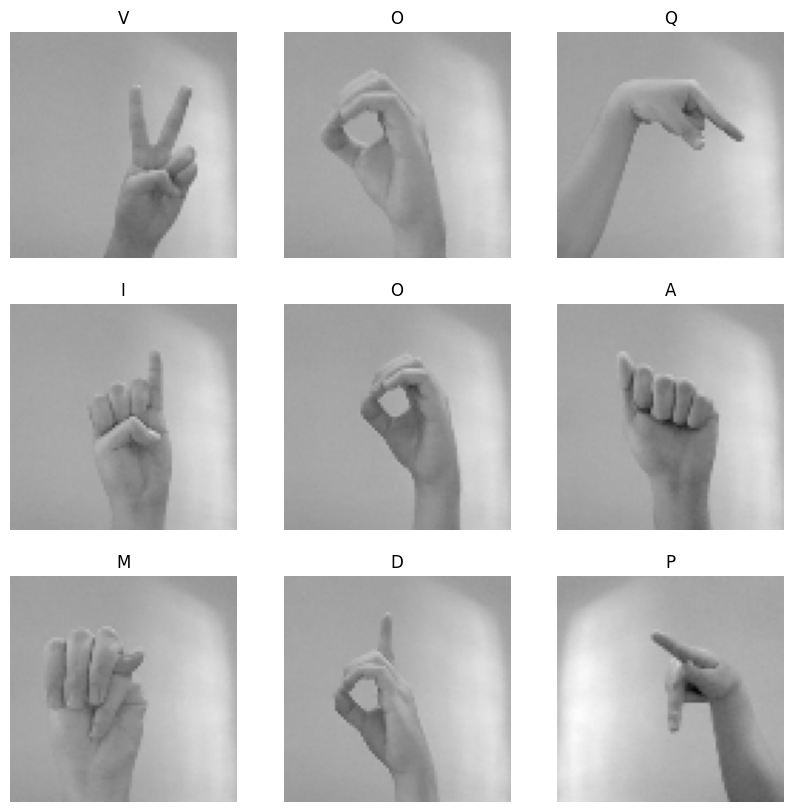

In [10]:
import matplotlib.pyplot as plt

# create a figure with specific figure size (in inches)
plt.figure(figsize=(10,10))

# take one batch of data
for images, labels in train_ds.take(1):
    # show the shape of an image
    print(images[0].shape)
    
    # display only 9 images
    for i in range(9):
        # in 3 rows and 3 columns
        ax = plt.subplot(3, 3, i+1)
        # take the image and convert back from TF Tensor to NumPy array
        # "uint8" is the dtype used for images because of the range of 0 to 255,
        # which is the general range of image pixel values
        plt.imshow(images[i].numpy().astype("uint8"))
        # get the label and show on top of image
        plt.title(class_name[labels[i]])
        plt.axis('off')
plt.show()

## Data augmentation using preprocessing layers

In [11]:
from tensorflow.keras.layers.experimental import preprocessing

# initialize our sequential data augmentation pipeline for training
trainAug = Sequential([
    preprocessing.Rescaling(scale=1.0 / 255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    preprocessing.RandomContrast(factor=0.1),
    ## You can add more data augmentation functions here, but adding them in this case
    ##  would only cause worse performance because these hand gestures should not
    ##  be flipped or rotated to be able to recognize them correctly
    # preprocessing.RandomFlip("horizontal"),
    # preprocessing.RandomRotation(factor=0.1),
])

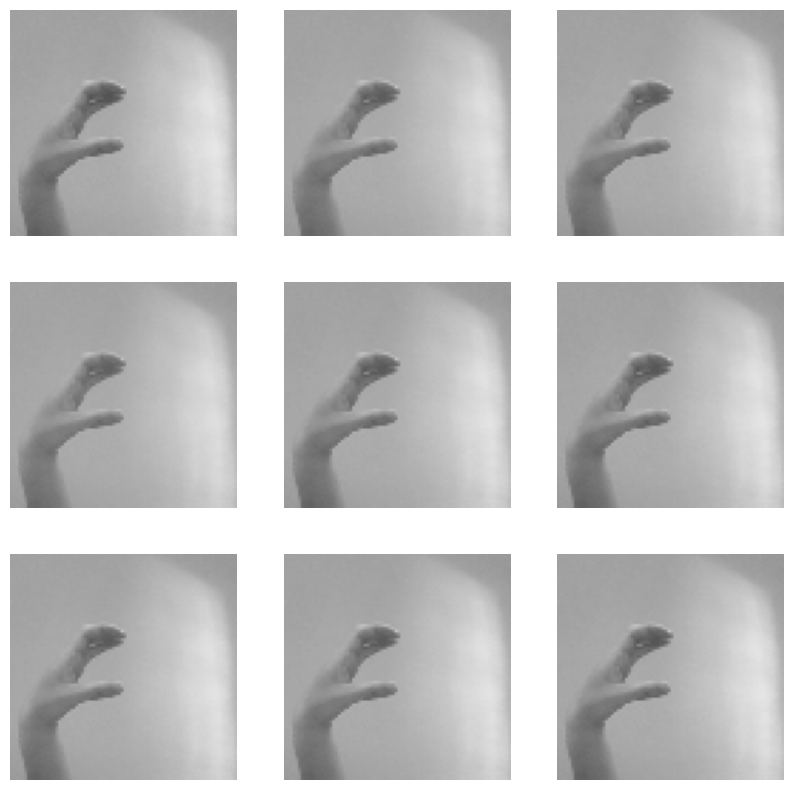

In [12]:
## Showing augmented images

for images, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # augment the image using the pipeline defined above
        augmented_image = trainAug(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0], cmap='gray')
        plt.axis('off')
plt.show()

The next code block will optimize the datasets for training and performance. This is what makes this method performs much faster than the ImageDataGenerator (the first method used in this notebook above).

Caching would cache a dataset, either in memory or on local storage to be used for the next epoch later.

While `prefetch` with `AUTOTUNE` (auto adjust the size to prefetch) makes our CPU to prefetch the data for the next batch during training to speed up the entire training pipeline.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (train_ds
            .shuffle(BATCH_SIZE * 100)
            .cache()
            .prefetch(AUTOTUNE)
)
val_ds = (val_ds
          # no shuffle
          .cache()
          .prefetch(AUTOTUNE)
)
test_ds = (test_ds
           # no shuffle
           .cache()
           .prefetch(AUTOTUNE)
)

## Build and train model

In [14]:
# take the number of classes
num_classes = len(CLASS_NAMES)

def create_model():
    tf.keras.backend.clear_session()
    model = Sequential([
        # Added data augmentation layer here, the rest is the same as 
        # the model defined previously in this notebook
        trainAug,
        
        # 1st conv block
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),

        # 2nd conv block
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),

        # 3rd conv block
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),

        # 4th conv block
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes)
    ])
    
    # compile the model
    print("[INFO] Compiling model...")
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer="adam",
        metrics=["accuracy"]
    )
    return model

model = create_model()
model.summary()

[INFO] Compiling model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 80, 80, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (

In [15]:
# train the model
print("[INFO] Training model...")
start_time = time.perf_counter()
H = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS
)
end_time = time.perf_counter()
print(f"[INFO] Total time: {end_time - start_time:.2f} s")

[INFO] Training model...
Epoch 1/10
260/260 [==============================] - 10s 15ms/step - loss: 2.5971 - accuracy: 0.2231 - val_loss: 0.8274 - val_accuracy: 0.7489
Epoch 2/10
260/260 [==============================] - 4s 14ms/step - loss: 0.3386 - accuracy: 0.9067 - val_loss: 0.1363 - val_accuracy: 0.9621
Epoch 3/10
260/260 [==============================] - 4s 14ms/step - loss: 0.0855 - accuracy: 0.9767 - val_loss: 0.0397 - val_accuracy: 0.9924
Epoch 4/10
260/260 [==============================] - 3s 13ms/step - loss: 0.0328 - accuracy: 0.9912 - val_loss: 0.0315 - val_accuracy: 0.9903
Epoch 5/10
260/260 [==============================] - 4s 13ms/step - loss: 0.0406 - accuracy: 0.9917 - val_loss: 0.0372 - val_accuracy: 0.9913: 0.0 - ETA: 
Epoch 6/10
260/260 [==============================] - 4s 14ms/step - loss: 0.0100 - accuracy: 0.9972 - val_loss: 0.0929 - val_accuracy: 0.9881
Epoch 7/10
260/260 [==============================] - 4s 14ms/step - loss: 0.0194 - accuracy: 0.9954 - 

The training time is much faster than the first method of using `ImageDataGenerator` class. 42 seconds VS 97 seconds (~43% faster)

## Evaluation

In [16]:
# show the accuracy on the validation set
(loss, accuracy) = model.evaluate(val_ds)
print("[INFO] Validation Accuracy: {:.2f}%".format(accuracy * 100))
# show the accuracy on the test set
(loss, accuracy) = model.evaluate(test_ds)
print("[INFO] Testing Accuracy: {:.2f}%".format(accuracy * 100))

29/29 [==============================] - 0s 6ms/step - loss: 0.0145 - accuracy: 0.9968
[INFO] Validation Accuracy: 99.68%
97/97 [==============================] - 1s 8ms/step - loss: 0.0323 - accuracy: 0.9925
[INFO] Testing Accuracy: 99.25%


<br>

Then display the results in detail for the test set

In [17]:
%%time
preds = model.predict(test_ds)
preds.shape

Wall time: 409 ms


(3080, 24)

In [18]:
preds = np.argmax(preds, axis=-1)
preds.shape

(3080,)

In [19]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true.shape

(3080,)

In [20]:
from sklearn.metrics import classification_report

# show a nicely formatted classification report
classif_report = classification_report(
    y_true, preds, target_names=CLASS_NAMES
)
print(classif_report)
with open(CLASSIF_REPORT_PATH, "w") as f:
    f.write(classif_report)

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       107
           B       0.98      1.00      0.99       128
           C       1.00      1.00      1.00       139
           D       1.00      0.98      0.99       123
           E       1.00      1.00      1.00       137
           F       0.96      1.00      0.98       109
           G       0.97      1.00      0.99       114
           H       1.00      0.99      1.00       141
           I       1.00      0.98      0.99       123
           K       0.99      1.00      1.00       136
           L       0.99      0.96      0.98       131
           M       0.99      0.97      0.98       126
           N       0.99      1.00      1.00       128
           O       1.00      1.00      1.00       131
           P       0.99      0.99      0.99       147
           Q       1.00      1.00      1.00       127
           R       1.00      1.00      1.00       124
           S       1.00    